# Intro

In this Notebook I am to explore the Titanic dataset from Kaggle competition https://www.kaggle.com/c/titanic. Much inspiration will be drawn from https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python.

# Initial explorations

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

In [3]:
data = pd.read_csv('titanic_train.csv')

In [4]:
data.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [5]:
data.shape

(891, 12)

In [6]:
missing = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum() / data.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat([missing, percent], axis = 1, keys = ['Missing', 'Percentage Missing'])

In [7]:
missing_data

,Missing,Percentage Missing
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


Seems like we will have to clean up the data with respect to the Age and Cabin columns.

## Target variable: Survived

In [8]:
data['Survived'].describe()

count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

38% survival rate!

In [361]:
print("Hello WOrld")

Hello WOrld


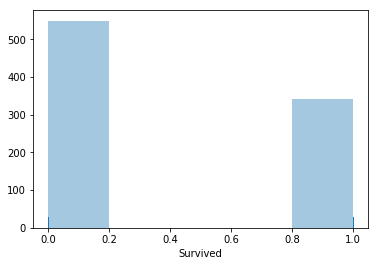

In [9]:
sns.distplot(data['Survived'], kde=False, rug=True)

## Independant variables

In [10]:
correlation_matrix = data.corr()

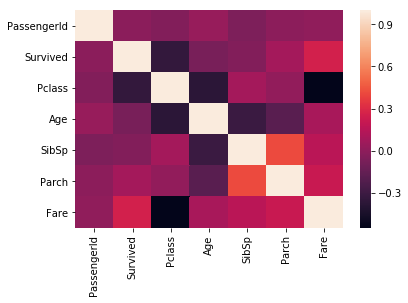

In [11]:
sns.heatmap(correlation_matrix)

### Name

In [12]:
data['Name'].value_counts().sort_values(ascending=False)[:10]

Simonius-Blumer, Col. Oberst Alfons          1
Foo, Mr. Choong                              1
Balkic, Mr. Cerin                            1
Goldenberg, Mr. Samuel L                     1
Pasic, Mr. Jakob                             1
Laroche, Mr. Joseph Philippe Lemercier       1
Stone, Mrs. George Nelson (Martha Evelyn)    1
West, Mrs. Edwy Arthur (Ada Mary Worth)      1
Mack, Mrs. (Mary)                            1
Waelens, Mr. Achille                         1
Name: Name, dtype: int64

All names are unique. So lets try to extract some usefull information from them.  
The all seem to follow the following structure:  
[Surname], [Title]. [First name]  
This information should be more valuable!

In [13]:
def regex_extract(s, regex, capture_group=1):
    search = re.search(regex, s)
    if search:
        return search.group(capture_group)
    else:
        return None

In [44]:
data['Title'] = data['Name'].apply(lambda x: regex_extract(x, ".*\,\s(.*?)\."))

data['Surname'] = data['Name'].apply(lambda x: regex_extract(x, "(.*)?\,"))

data['First name'] = data['Name'].apply(lambda x: regex_extract(x, ".*?\.\s(.*)"))

In [55]:
data = data.drop('Name', axis = 1)

In [75]:
print("Number of passengers: {}".format(data.shape[0]))
print("Number of unique titles: {}".format(data['Title'].nunique()))
print("Number of unique surnames: {}".format(data['Surname'].nunique()))
print("Number of unique first names: {}".format(data['First name'].nunique()))

Number of passengers: 891
Number of unique titles: 17
Number of unique surnames: 667
Number of unique first names: 799


Title seems like Title could be a potent feature! Not to many unique values.

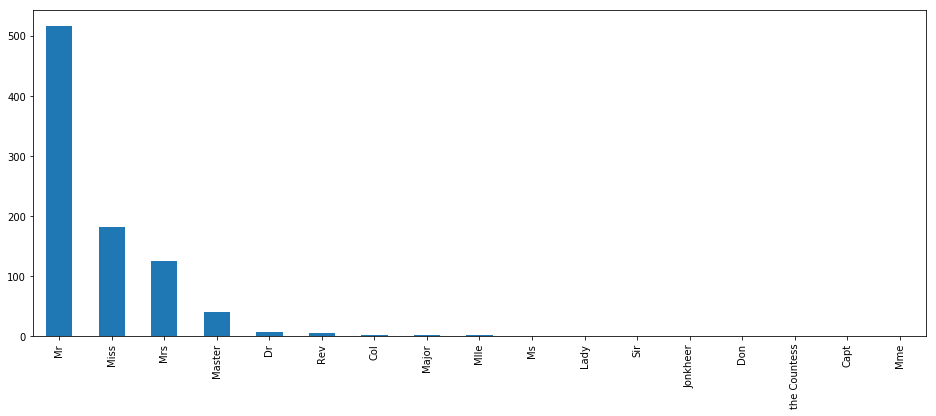

In [78]:
plt.figure(figsize=(16,6))
data['Title'].value_counts().plot('bar')

Lets check if Title correlates with Survived for the more common titles:  
* Mr
* Miss
* Mrs
* Master

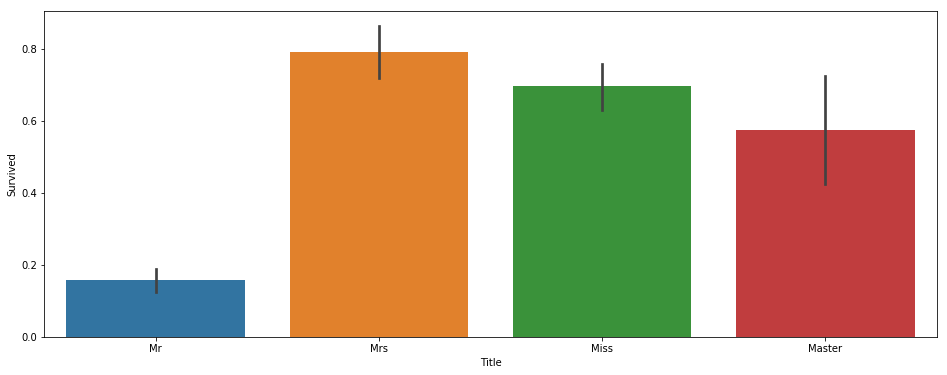

In [99]:
plt.figure(figsize=(16,6))
sns.barplot(x="Title", y="Survived", data=data[data['Title'].apply(lambda x: x in ['Mr', 'Miss', 'Mrs', 'Master'])])

Looks like most people with the title Mr died. Most likely we see the same story for most men.

When it comes to the other two name variables there are far to many unique values to look for correlations this way. My theory is that surname might be used to identify families, and maybe infer information about survival that way. Maybe families often met the same fate due to sticking together? First name can likely be ignored. 

### Sex

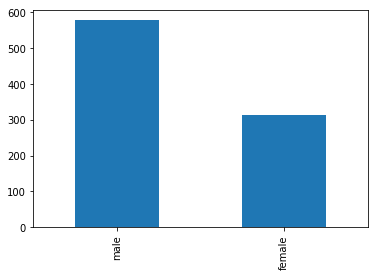

In [82]:
data['Sex'].value_counts().plot('bar')

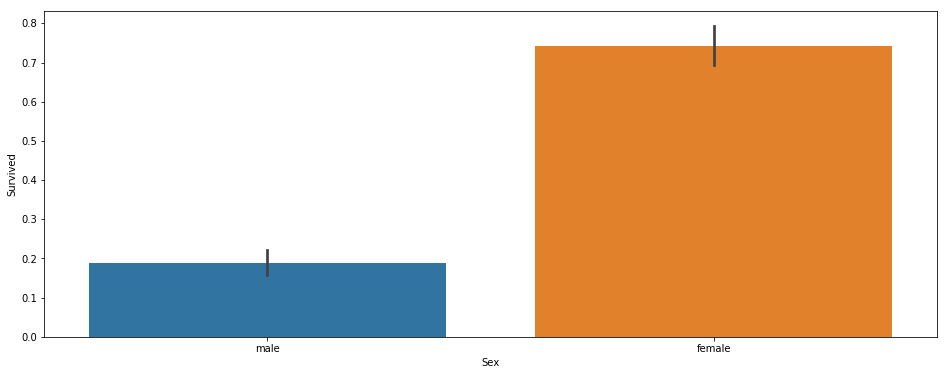

In [97]:
plt.figure(figsize=(16,6))
sns.barplot(x="Sex", y="Survived", data=data)

Similar story as before, survival rate is much lower from men. But thanks to Title we might be able to distinguish some men with higher survival rate (Masters).

### Pclass

From Data description on Kaggle:  
pclass: A proxy for socio-economic status (SES)  
1st = Upper  
2nd = Middle  
3rd = Lower  

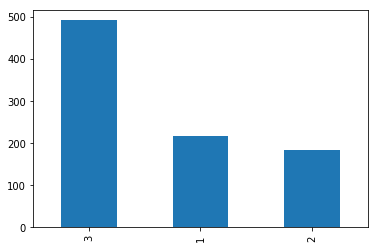

In [87]:
data['Pclass'].value_counts().plot('bar')

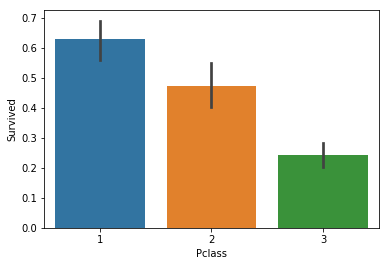

In [88]:
sns.barplot(x='Pclass', y='Survived', data=data)

Pclass is definitely an ordered categorical. With survival rate dropping with lower class.

### Age

In [89]:
missing_data.loc['Age']

Missing               177.000000
Percentage Missing      0.198653
Name: Age, dtype: float64

Almost 20% of data is missing the Age column. Lets explore if we can find a pattern. Otherwise we might have to discard these rows.

In [85]:
missing_age = data[data['Age'].isnull()]

In [90]:
missing_age.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q


In [104]:
missing_age['Pclass'].value_counts()

3    136
1     30
2     11
Name: Pclass, dtype: int64

In [105]:
missing_age['Sex'].value_counts()

male      124
female     53
Name: Sex, dtype: int64

In [106]:
missing_age['Survived'].value_counts()

0    125
1     52
Name: Survived, dtype: int64

Data is missing from all categories of passengers. It looks like we might have to discard either those rows or the Age variable. But lets explore if the variable seems to infer any information about survival first.

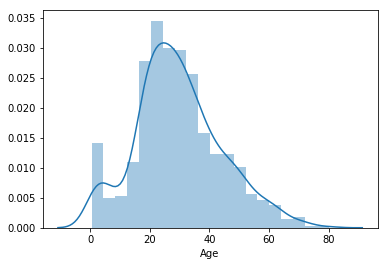

In [90]:
sns.distplot(data['Age'].dropna())

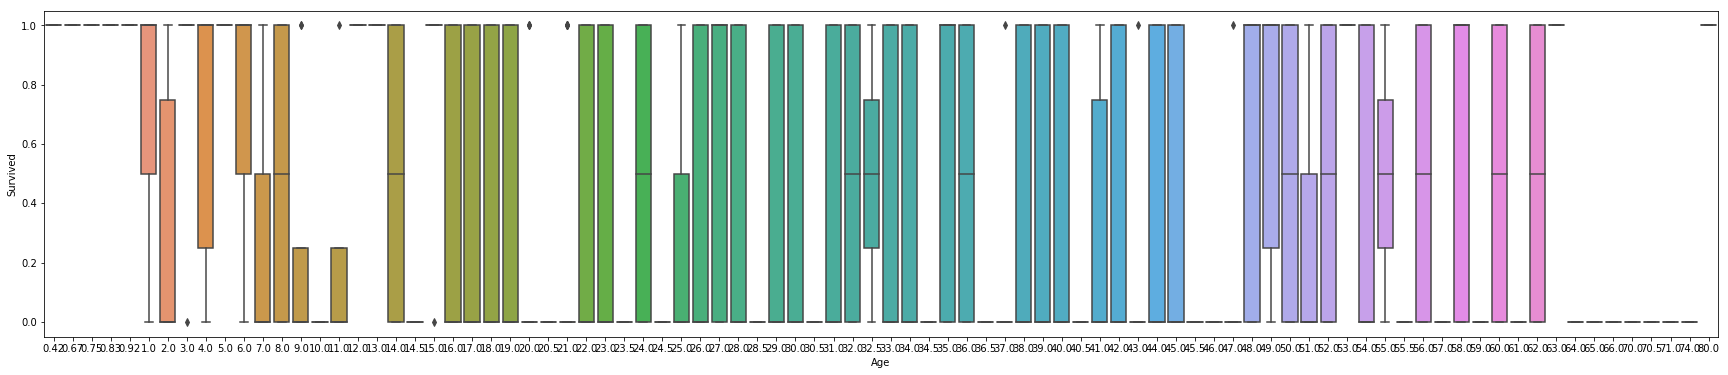

In [95]:
plt.figure(figsize=(30,6))
sns.boxplot(x='Age', y='Survived', data=data)

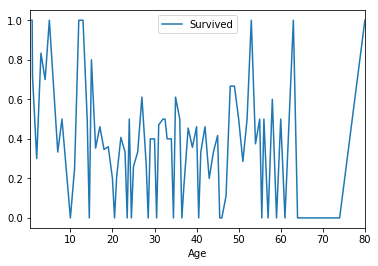

In [106]:
data.groupby('Age').mean().plot(y="Survived")

Looks like survivalrate is higher for younger passengers. Is this enough to warrant keeping a variable that is missing 20% of data? Maybe we can try to verify this in a later stage based on accuracy.

### Embarked

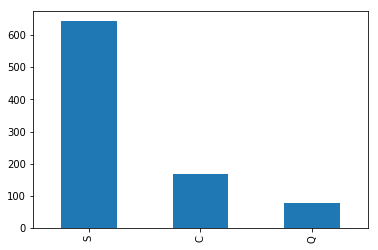

In [109]:
data['Embarked'].value_counts().plot('bar')

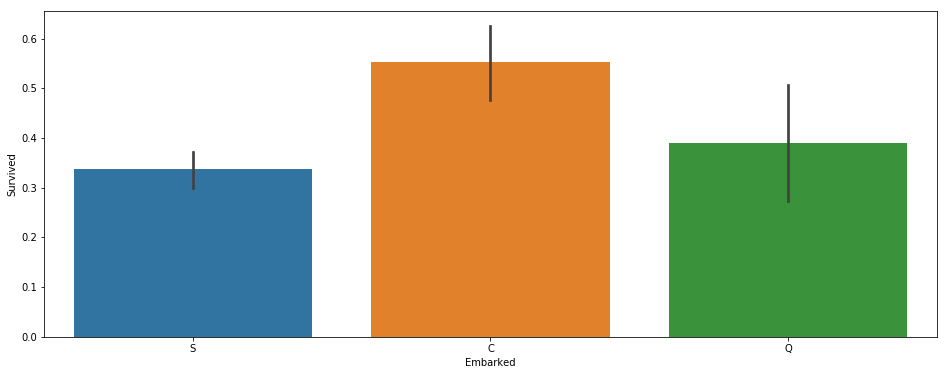

In [111]:
plt.figure(figsize=(16,6))
sns.barplot(x='Embarked', y='Survived', data=data)

Embarked seems to carry some information relevant to survival!

### Cabin

In [114]:
missing_data.loc['Cabin']

Missing               687.000000
Percentage Missing      0.771044
Name: Cabin, dtype: float64

Cabin is missing in 77% of data. But could it still carry information? Maybe a missing cabin entry means the passenger had no cabin?

In [115]:
missing_cabin = data[data['Cabin'].isnull()]

In [123]:
missing_cabin['Pclass'].value_counts()

3    479
2    168
1     40
Name: Pclass, dtype: int64

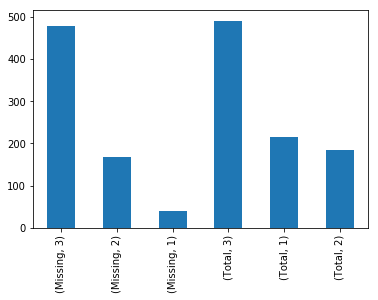

In [125]:
pd.concat([missing_cabin['Pclass'].value_counts(), data['Pclass'].value_counts()], keys=['Missing', 'Total']).plot('bar')

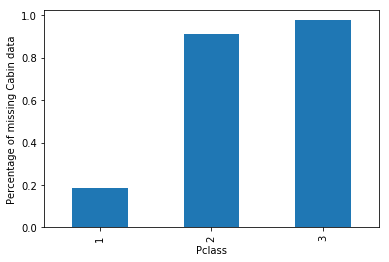

In [130]:
(missing_cabin['Pclass'].value_counts()/ data['Pclass'].value_counts()).plot('bar')
plt.ylabel('Percentage of missing Cabin data')
plt.xlabel('Pclass')

In [134]:
(missing_cabin['Pclass'].value_counts()/ data['Pclass'].value_counts())

1    0.185185
2    0.913043
3    0.975560
Name: Pclass, dtype: float64

Look like most people in third and second class are missing Cabin data. Could this strengthen my theory that a missing Cabin entry means that the passenger had no cabin?

In [171]:
cabin_grouped = data.copy()

In [172]:
cabin_grouped = cabin_grouped.fillna('No cabin')

In [173]:
cabin_grouped['Cabin'] = cabin_grouped['Cabin'].apply(lambda x: "Cabin" if x != 'No cabin' else "No cabin")

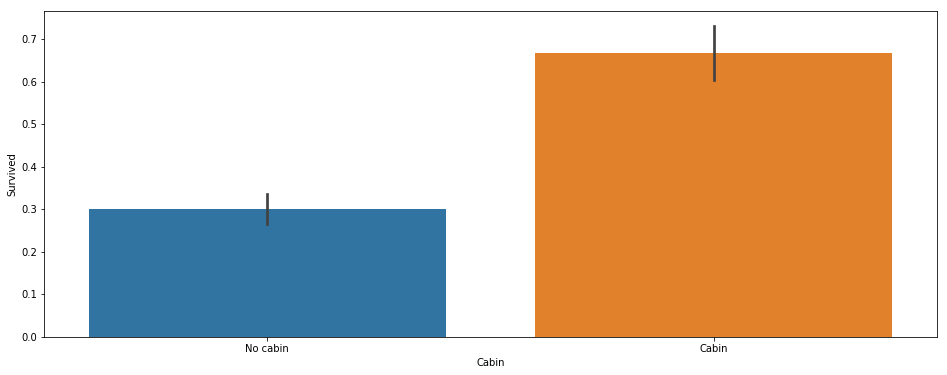

In [174]:
plt.figure(figsize=(16,6))
sns.barplot(x='Cabin', y='Survived', data=cabin_grouped)

I definitely want to try using this assumption an meassure accuracy!

### Ticket

Playing around a little with the data has me thinking that passengers that bought their ticket together have the same ticket ID. For example families, but also nannies traveling with a familly. But lets investigate further.

In [175]:
data['Ticket'].nunique()

681

In [176]:
data['Surname'].nunique()

667

Maybe there is a correlation with surname?

In [224]:
data[data.duplicated(subset=['Ticket', 'Surname'], keep = False)].sort_values(['Ticket', 'Surname']).shape

(251, 17)

In [225]:
data[data.duplicated(subset=['Ticket'], keep = False)].sort_values(['Ticket']).shape

(344, 17)

In [226]:
data[data.duplicated(subset=['Surname'], keep = False)].sort_values(['Ticket']).shape

(357, 17)

251 out of 344 passengers that shared ticket ID with someone else also shared surname!

I have a theory that familly / companionship relations will tell much about survival rate within the family. If a child has died it seems unlikely that it's parents did etc. Therefore I would like to create a column with survival rate of travel companions. It seems like we could infer if companionship from Surname, Ticket and Cabin. Lets investigate further!

In [228]:
same_surname = data[data.duplicated(subset=['Surname'], keep = False)].sort_values(['Surname'])

same_surname[same_surname.duplicated(subset=['Ticket'], keep = False).apply(lambda x: not x)]

Skimming through the list of people with shared Surnames but different tickets has me thinking that a lot of them probably are not companions. Just sharing surname seems like to weak of a connection.

In [236]:
same_ticket = data[data.duplicated(subset=['Ticket'], keep = False)].sort_values(['Ticket'])

same_ticket[same_ticket.duplicated(subset=['Surname'], keep = False).apply(lambda x: not x)]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname,First name,Children,Parents,Child
257,258,1,1,female,30.0,0,0,110152,86.5000,B77,S,Miss,Cherry,Gladys,0.0,NaN,False
759,760,1,1,female,33.0,0,0,110152,86.5000,B77,S,the Countess,Rothes,of (Lucy Noel Martha Dyer-Edwards),0.0,NaN,False
504,505,1,1,female,16.0,0,0,110152,86.5000,B79,S,Miss,Maioni,Roberta,NaN,0.0,True
110,111,0,1,male,47.0,0,0,110465,52.0000,C110,S,Mr,Porter,Walter Chamberlain,0.0,NaN,False
475,476,0,1,male,NaN,0,0,110465,52.0000,A14,S,Mr,Clifford,George Quincy,0.0,NaN,False
166,167,1,1,female,NaN,0,1,113505,55.0000,E33,S,Mrs,Chibnall,(Edith Martha Bowerman),1.0,NaN,False
356,357,1,1,female,22.0,0,1,113505,55.0000,E33,S,Miss,Bowerman,Elsie Edith,1.0,NaN,False
829,830,1,1,female,62.0,0,0,113572,80.0000,B28,NaN,Mrs,Stone,George Nelson (Martha Evelyn),0.0,NaN,False
61,62,1,1,female,38.0,0,0,113572,80.0000,B28,NaN,Miss,Icard,Amelie,0.0,NaN,False
708,709,1,1,female,22.0,0,0,113781,151.5500,NaN,S,Miss,Cleaver,Alice,0.0,NaN,False


I feel like it's more likely that Ticket infers companionship. If you bought your ticket together you likely have some kind of relationship! Lets check cabin too.

In [240]:
same_ticket = data[(data.duplicated(subset=['Cabin'], keep = False)) & (data['Cabin'].notnull())].sort_values(['Cabin'])

same_ticket[same_ticket.duplicated(subset=['Ticket'], keep = False).apply(lambda x: not x)].shape

(23, 17)

Sharing a Cabin likely also tells us something about survival rate. But there are just 23 people sharing cabin with someone else that do not share ticket. I will only infer companionship from a shared ticket.

In [254]:
tickets = data.groupby(['Ticket']).agg({'Survived' : 'sum', 'PassengerId' : 'count'}).rename(columns={'Survived' : 'SurvivedInCompany','PassengerId' : 'CompanySize'}).reset_index()

In [255]:
data = data.merge(tickets, on = 'Ticket', how = 'left')

When making preictions we don't have access to the passengers survival status (duh), so we should never take that into account. So that information has to be discarded.

In [270]:
data['SurvivingCompanions'] = data.apply(lambda row: row['SurvivedInCompany'] - row['Survived'], axis=1)
data['DeadCompanions'] = data.apply(lambda row: row['CompanySize'] - row['SurvivedInCompany'] + row['Survived'], axis=1)
data['CompanySurvivalRate'] = data.apply(lambda row: row['SurvivingCompanions'] / (row['CompanySize'] - 1) if row['CompanySize'] > 1 else None, axis=1)

#(data['SurvivingCompanions'] / (data['SurvivingCompanions'] + data['DeadCompanions'])


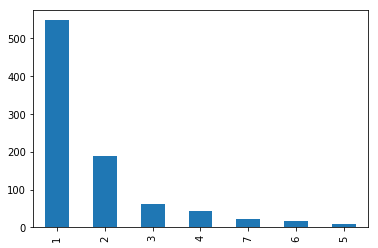

In [271]:
data['CompanySize'].value_counts().plot('bar')

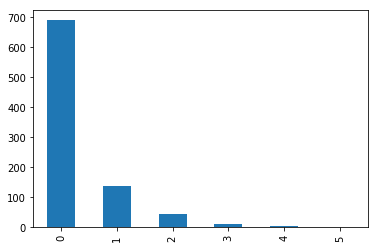

In [272]:
data['SurvivingCompanions'].value_counts().plot('bar')

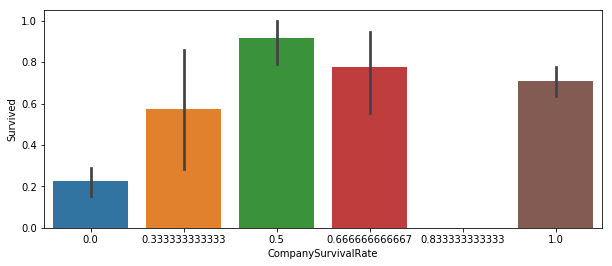

In [275]:
plt.figure(figsize=(10,4))
sns.barplot(x='CompanySurvivalRate', y='Survived', data=data)

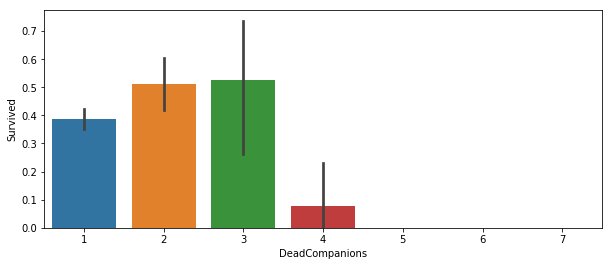

In [276]:
plt.figure(figsize=(10,4))
sns.barplot(x='DeadCompanions', y='Survived', data=data)

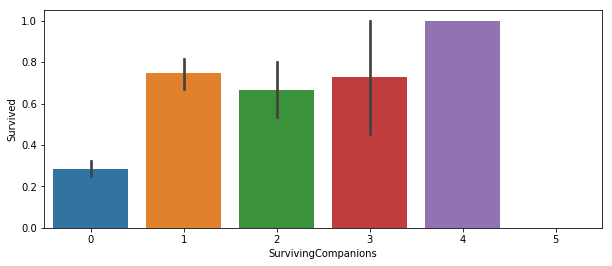

In [277]:
plt.figure(figsize=(10,4))
sns.barplot(x='SurvivingCompanions', y='Survived', data=data)

Having surviving companions definitely seems to increase survival rate. Having dead companions seems to have less effect on ones own survival rate. Lets look at how having company affects survival rate.

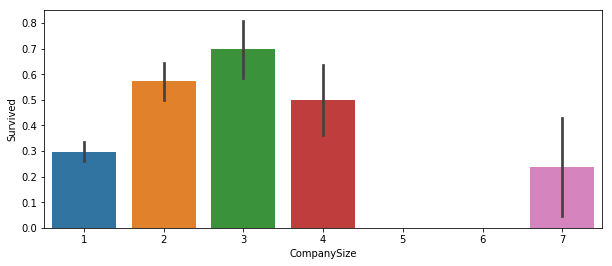

In [278]:
plt.figure(figsize=(10,4))
sns.barplot(x='CompanySize', y='Survived', data=data)

### SibSP and Parch

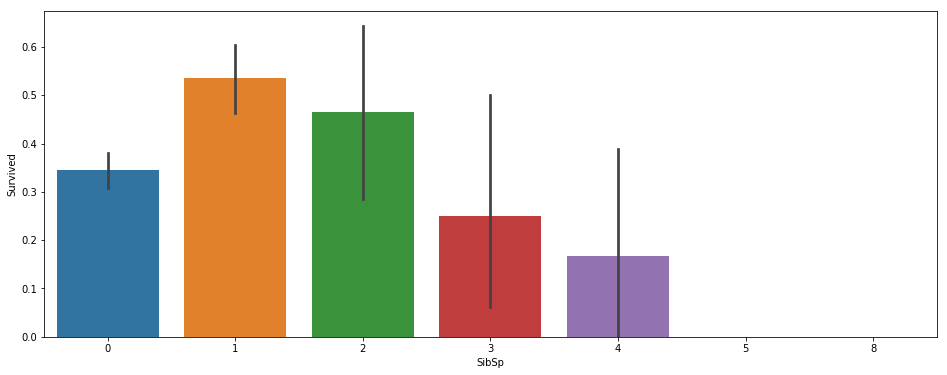

In [189]:
plt.figure(figsize=(16,6))
sns.barplot(x='SibSp', y='Survived', data=data)

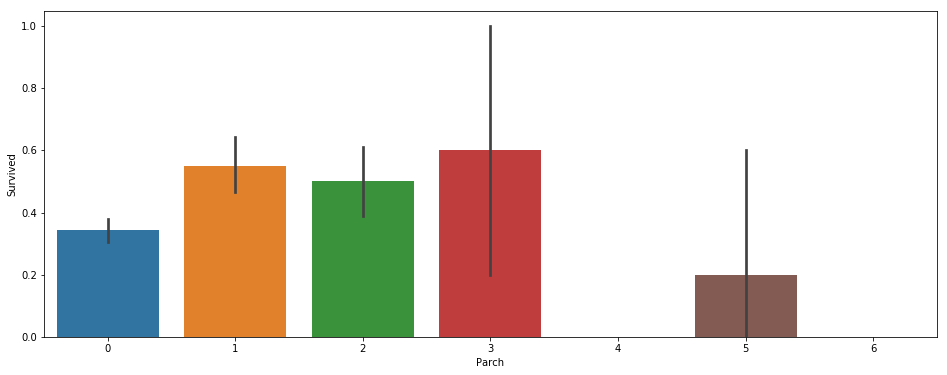

In [192]:
plt.figure(figsize=(16,6))
sns.barplot(x='Parch', y='Survived', data=data)

Looks like both values infer information about survival rate. Hard to tell in what way though. Lets try to separate parents and children. For simplicitys sake I will assume that you are a child if you are younger than 18 and a parent if you 18 or older.

In [216]:
data['Child'] = data['Age'].apply(lambda x: x < 18)

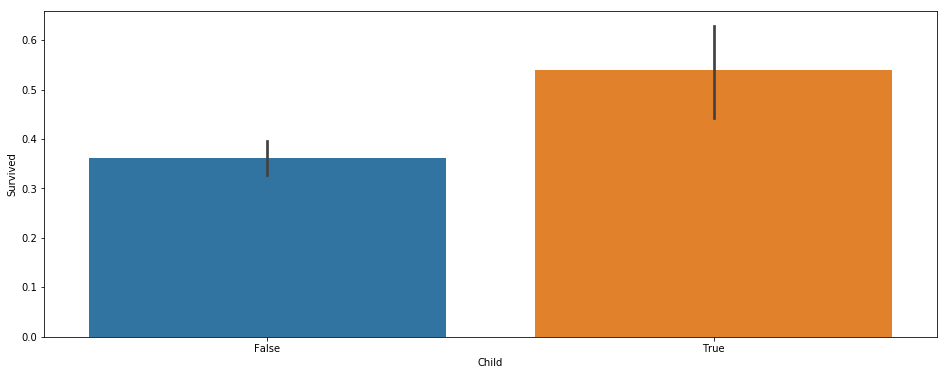

In [220]:
plt.figure(figsize=(16,6))
sns.barplot(x='Child', y='Survived', data=data)

Higher survival rate for children, just like we saw earlier.

In [217]:
data['Children'] = data.apply(lambda row: row['Parch'] if not row['Child'] else None, axis=1)
data['Parents'] = data.apply(lambda row: row['Parch'] if row['Child'] else None, axis=1)

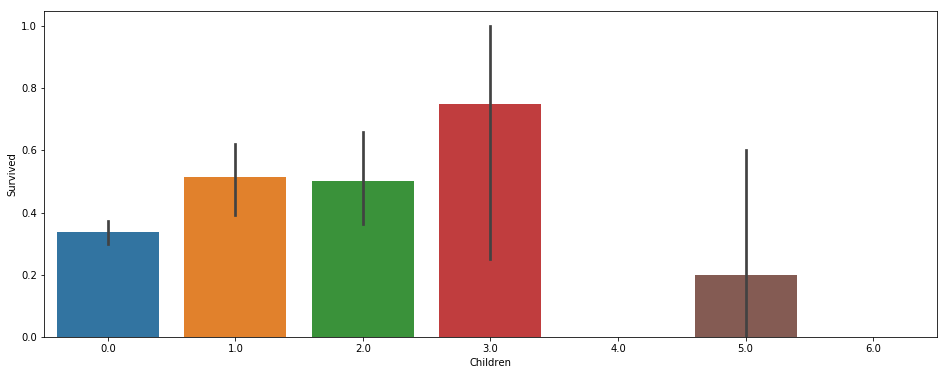

In [218]:
plt.figure(figsize=(16,6))
sns.barplot(x='Children', y='Survived', data=data)

Looks like we might have found a trend!

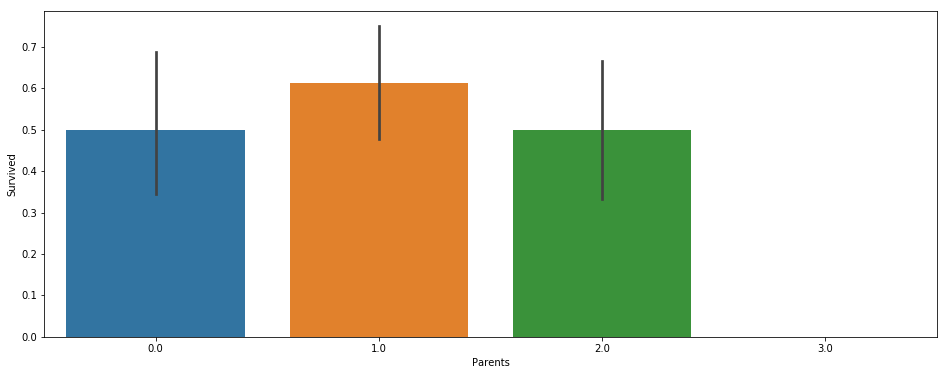

In [219]:
plt.figure(figsize=(16,6))
sns.barplot(x='Parents', y='Survived', data=data)

Having a single parent onboard seems advantageous for children. Bur maybe I am inventing reduntant features? If they are carrying information found in other features they wont be of mich use. I would like to test out later, maybe using logical regression? But first lets invent some more!

## Conclusions

In [283]:
missing = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum() / data.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat([missing, percent], axis = 1, keys = ['Missing', 'Percentage Missing'])

In [284]:
missing_data

,Missing,Percentage Missing
Parents,778,0.873176
Cabin,687,0.771044
CompanySurvivalRate,547,0.613917
Age,177,0.198653
Children,113,0.126824
Embarked,2,0.002245
Child,0,0.000000
SurvivedInCompany,0,0.000000
First name,0,0.000000
Surname,0,0.000000
